# Imports

In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde, norm, gamma
from sklearn.neighbors import KernelDensity
import seaborn as sns
from theano import tensor as tt

# Simple examples

## Normal parameterisation

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [stdev, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


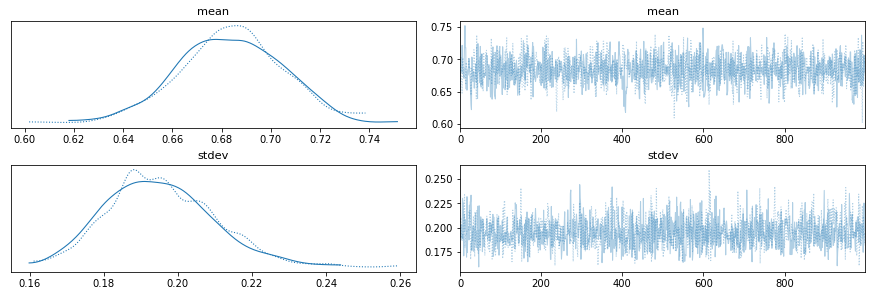

In [2]:
obs = np.random.normal(0.7, 0.2, 100)

with pm.Model() as test:
    # priors
    mean = pm.Normal('mean', mu=1., sd=0.5)
    stdev = pm.HalfNormal('stdev', sd=0.3)
    
    # parameterisation (specifies likelihood)
    y = pm.Normal('y', mu=mean, sd=stdev, observed=obs)
    
    # sample from the posterior
    trace = pm.sample(return_inferencedata=True)
    
    # plot
    pm.plot_trace(trace)

## Bernoulli with a log odds prior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [log_odds]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 14 seconds.


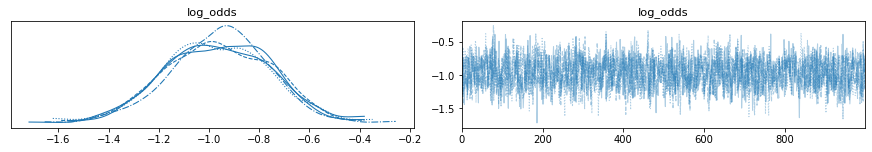

In [3]:
obs = np.random.rand(100) < 0.3

with pm.Model() as log_reg:
    # priors
    log_odds = pm.Normal('log_odds', mu=0., sd=0.5)
    prob = pm.math.invlogit(log_odds) # for reference - not used
    
    # parameterisation (specifies likelihood)
    y = pm.Bernoulli('y', logit_p=log_odds, observed=obs)
    
    # sample from the posterior
    trace = pm.sample(return_inferencedata=True, chains=5)
    
    # plot
    pm.plot_trace(trace)

## Bernoulli with a Beta prior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [prob]


Sampling 5 chains for 500 tune and 3_000 draw iterations (2_500 + 15_000 draws total) took 17 seconds.


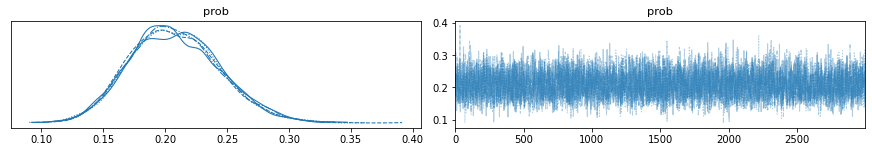

In [4]:
obs = np.random.rand(100) < 0.3

with pm.Model() as log_reg:
    # priors
    prob = pm.Beta('prob', 5, 20)
    
    # parameterisation (specifies likelihood)
    y = pm.Bernoulli('y', p=prob, observed=obs)
    
    # sample from the posterior
    trace = pm.sample(return_inferencedata=True, chains=5, tune=500, draws=3000)
    
    # plot
    pm.plot_trace(trace)

# Custom priors and likelihoods using DensityDist

## Create a weird custom distribution

In [5]:
lower_bound = -10.
upper_bound = 10.
resolution = 50
smooth_width = 5

x_points = np.linspace(lower_bound, upper_bound, resolution)
pdf_points = np.random.rand(resolution+smooth_width-1)
pdf_smooth = np.convolve(pdf_points, np.ones(smooth_width))[smooth_width-1:1-smooth_width]

# this distribution will be automatically normalised
noisy_dist = pm.Interpolated.dist(x_points, pdf_smooth)

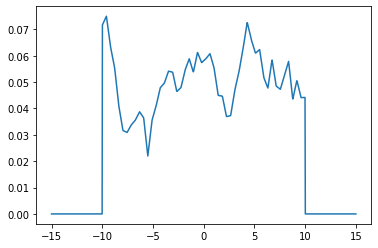

In [6]:
x_plot = np.linspace(lower_bound - 5., upper_bound + 5.0, 1000)
y_plot = np.exp(noisy_dist.logp(x_plot).eval())
plt.plot(x_plot, y_plot);

## Use noisy_dist as a prior over mu

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [stdev, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


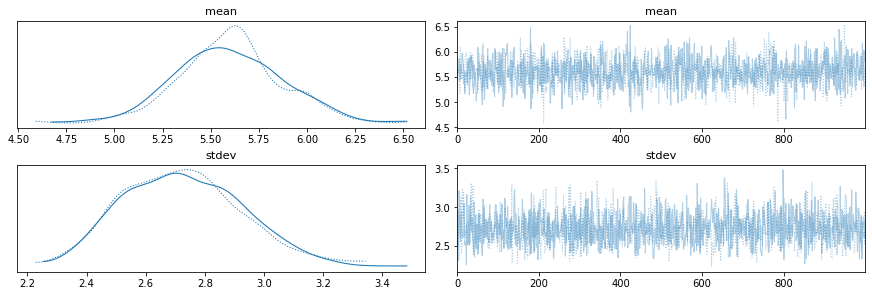

In [7]:
obs = np.random.normal(6., 3., 100)

with pm.Model() as test:
    # define custom function to return prior density
    def prior_density(value):
        return noisy_dist.logp(value)
    
    # priors
    mean = pm.DensityDist('mean', logp=prior_density)
    stdev = pm.HalfNormal('stdev', sd=5.)
    
    # parameterisation (specifies likelihood)
    y = pm.Normal('y', mu=mean, sd=stdev, observed=obs)
    
    # sample from the posterior
    trace = pm.sample(return_inferencedata=True)
    
    # plot
    pm.plot_trace(trace)

## Use custom parameterisation with shifted noisy_dist
NB - this isn't a very sensible example! However it does show how you would go about creating a custom likelihood function. One thing to watch out for is that log_p goes to -inf outside the support range of noisy_dist. This would have to be manually addressed in a real example.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [shift_factor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


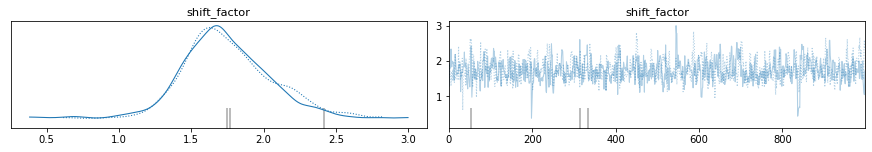

In [8]:
obs = np.random.normal(2., 2., 100)

with pm.Model() as test:
    # priors
    shift_factor = pm.Normal('shift_factor', mu=0., sd=2.)
    
    # define custom function to return log likelihood for a given sample from the prior
    # in this case, the shift_factor by which we shift the noisy_dist pdf
    def log_p(value):
        return noisy_dist.logp(value - shift_factor)
    
    # parameterisation (specifies likelihood)
    y = pm.DensityDist('y', logp=log_p, observed=obs)
    
    # sample from the posterior
    trace = pm.sample(return_inferencedata=True)
    
    # plot
    pm.plot_trace(trace)